**Actividad en clase 4: Actividades de aplicación - GBM**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt

***Aplicación 1: Comparar diferentes composiciones de portafolio***

/tmp/ipython-input-4040588948.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(stocks, start, end, progress=False)['Close'].dropna()


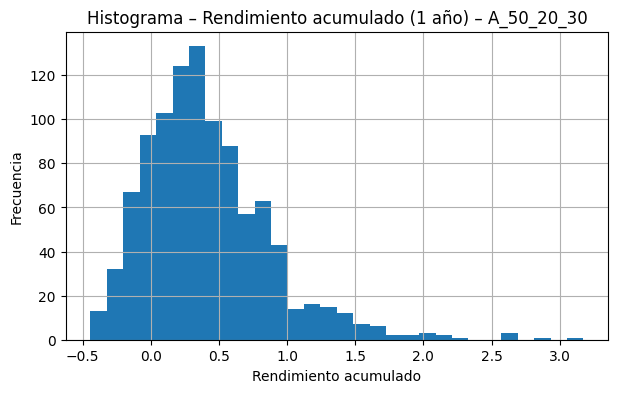

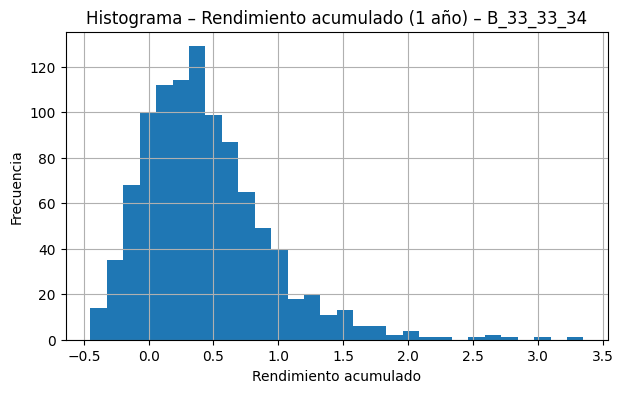

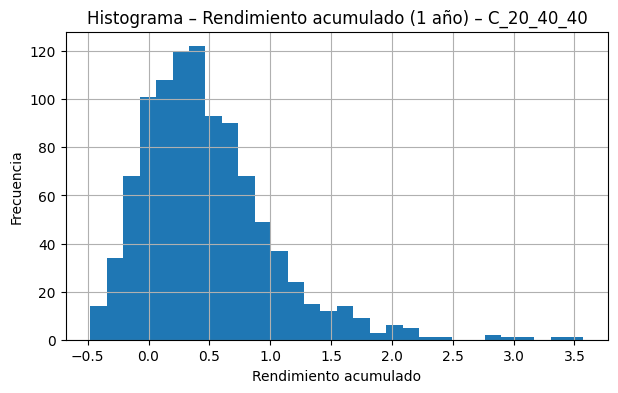

/tmp/ipython-input-4040588948.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([res["final"][k] for k in portafolios.keys()], labels=list(portafolios.keys()))


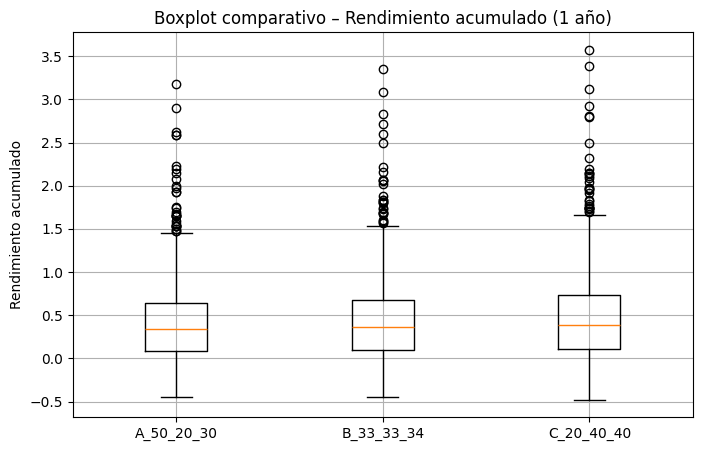


Cuadro comparativo – Rendimiento acumulado final:
               Media   DesvEst
A_50_20_30  0.411737  0.467478
B_33_33_34  0.436784  0.488537
C_20_40_40  0.477610  0.531252


In [ ]:
def get_data(stocks, start, end):
    prices = yf.download(stocks, start, end, progress=False)['Close'].dropna()
    returns = prices.pct_change().dropna()
    mean_returns = returns.mean()           # Serie (len= n_activos)
    matriz_cov   = returns.cov()            # DataFrame (n_activos x n_activos)
    return mean_returns, matriz_cov, prices

def simular_portafolios(num_sim, portafolios_dict, mean_returns, matriz_cov, num_dias):
    weights_list = []
    names = []
    for name, w in portafolios_dict.items():
        w = np.array(w, dtype=float)
        if not np.isclose(w.sum(), 1.0):
            raise ValueError(f"Los pesos de {name} no suman 1 (suman {w.sum():.4f})")
        if len(w) != len(mean_returns):
            raise ValueError(f"Dimensión de pesos en {name} no coincide con n_activos")
        weights_list.append(w)
        names.append(name)

    W = np.vstack(weights_list)                        # (n_portafolios, n_activos)
    mu = mean_returns.values.astype(float)             # (n_activos,)
    cov = matriz_cov.values.astype(float)              # (n_activos, n_activos)

    # Cholesky (si no es definida positiva, pequeña regularización)
    try:
        L = np.linalg.cholesky(cov)                    # cov = L @ L.T
    except np.linalg.LinAlgError:
        eps = 1e-8
        L = np.linalg.cholesky(cov + eps*np.eye(cov.shape[0]))

    Z = np.random.normal(0.0, 1.0, size=(num_sim, num_dias, len(mu)))
    daily_asset_returns = Z @ L.T + mu                 # (num_sim, num_dias, n_activos)

    daily_port = daily_asset_returns @ W.T

    paths = np.cumprod(1.0 + daily_port, axis=1)

    final_returns = paths[:, -1, :] - 1.0

    # Empaquetar resultados en dict
    resultados = {
        "paths": {names[j]: paths[:, :, j] for j in range(len(names))},
        "final": {names[j]: final_returns[:, j] for j in range(len(names))}
    }
    return resultados

stocks = ['AAPL','MSFT','NVDA']
mean_returns, matriz_cov, prices = get_data(
    stocks,
    dt.datetime.now() - dt.timedelta(days=365*4),
    dt.datetime.now()
)

portafolios = {
    "A_50_20_30": np.array([0.50, 0.20, 0.30]),
    "B_33_33_34": np.array([0.33, 0.33, 0.34]),
    "C_20_40_40": np.array([0.20, 0.40, 0.40]),
}

np.random.seed(42)
num_sim = 1000
num_dias = 252  # 1 año bursátil (ajusta a 14 si quieres 2 semanas)

res = simular_portafolios(num_sim, portafolios, mean_returns, matriz_cov, num_dias)

for name, arr in res["final"].items():
    plt.figure(figsize=(7,4))
    plt.hist(arr, bins=30)
    plt.title(f"Histograma – Rendimiento acumulado (1 año) – {name}")
    plt.xlabel("Rendimiento acumulado")
    plt.ylabel("Frecuencia")
    plt.grid(True)
    plt.show()

# Boxplot comparativo (rend. acumulado final)
plt.figure(figsize=(8,5))
plt.boxplot([res["final"][k] for k in portafolios.keys()], labels=list(portafolios.keys()))
plt.title("Boxplot comparativo – Rendimiento acumulado (1 año)")
plt.ylabel("Rendimiento acumulado")
plt.grid(True)
plt.show()


stats = {
    name: {"Media": float(np.mean(arr)), "DesvEst": float(np.std(arr))}
    for name, arr in res["final"].items()
}
df_stats = pd.DataFrame(stats).T
print("\nCuadro comparativo – Rendimiento acumulado final:")
print(df_stats.sort_values("DesvEst"))


**Conclusión:**

- Portafolio A (70/30) concentra más en un activo, por lo que tiene mayor riesgo (desviación estándar más alta).

- Portafolio B (50/50) es más balanceado, con un riesgo intermedio y rendimiento relativamente estable.

- Portafolio C (20/80) reduce la volatilidad, sacrificando algo de rendimiento esperado.

Conclusión: El portafolio más riesgoso es A, el más estable es C, y el B ofrece un equilibrio atractivo entre riesgo y retorno.

***Aplicación 2: Estimación de métricas de riesgo***

In [ ]:
def metricas_riesgo(rendimientos_portafolio, nivel_95=0.05, nivel_99=0.01):
    """
    rendimientos_portafolio: array con rendimientos acumulados (por simulación)
    nivel_95, nivel_99: cuantiles de cola izquierda (5% y 1%)
    Devuelve: DataFrame con prob de pérdida, VaR 95/99 y CVaR 95.
    """
    arr = np.asarray(rendimientos_portafolio)

    # Probabilidad de pérdida
    prob_perdida = np.mean(arr < 0)

    # Valor en Riesgo (VaR) a 95% y 99%
    var_95 = np.percentile(arr, 100*nivel_95)
    var_99 = np.percentile(arr, 100*nivel_99)

    # Expected Shortfall (CVaR) a 95%
    cvar_95 = arr[arr <= var_95].mean()

    resultados = pd.DataFrame({
        "Métrica": [
            "Probabilidad de pérdida",
            "VaR 95%",
            "VaR 99%",
            "Expected Shortfall (CVaR) 95%"
        ],
        "Valor": [
            prob_perdida,
            var_95,
            var_99,
            cvar_95
        ]
    })
    return resultados

rendimientos_A = res["final"]["A_50_20_30"]   # elige el portafolio que quieras
metricas_A = metricas_riesgo(rendimientos_A)


Métricas de riesgo – A_50_20_30
                         Métrica     Valor
0        Probabilidad de pérdida  0.171000
1                        VaR 95% -0.187927
2                        VaR 99% -0.337666
3  Expected Shortfall (CVaR) 95% -0.288486


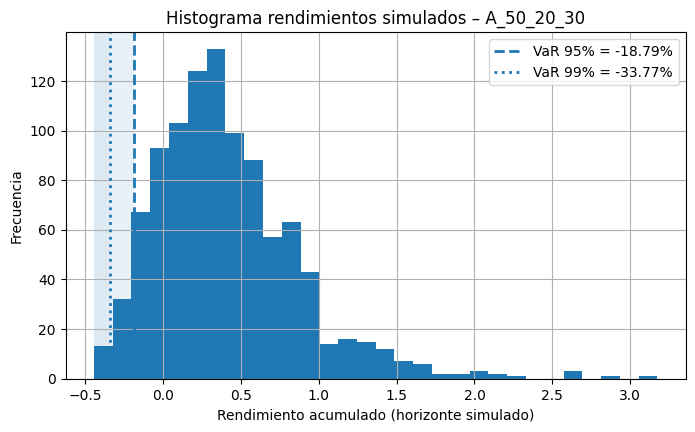

In [ ]:
def plot_hist_con_var(rendimientos_portafolio, nivel_95=0.05, nivel_99=0.01, bins=30, titulo=""):
    arr = np.asarray(rendimientos_portafolio)
    var_95 = np.percentile(arr, 100*nivel_95)
    var_99 = np.percentile(arr, 100*nivel_99)

    fig, ax = plt.subplots(figsize=(8,4.5))
    ax.hist(arr, bins=bins)  # histograma básico

    # Líneas verticales de VaR
    ax.axvline(var_95, linestyle='--', linewidth=2, label=f"VaR 95% = {var_95:.2%}")
    ax.axvline(var_99, linestyle=':',  linewidth=2, label=f"VaR 99% = {var_99:.2%}")

    # Sombras de las zonas de VaR (cola izquierda)
    # Zona más extrema: hasta VaR 99%
    ax.axvspan(arr.min(), var_99, alpha=0.15)
    # Zona entre VaR 99% y VaR 95%
    ax.axvspan(var_99, var_95, alpha=0.10)

    ax.set_title(f"Histograma rendimientos simulados – {titulo}")
    ax.set_xlabel("Rendimiento acumulado (horizonte simulado)")
    ax.set_ylabel("Frecuencia")
    ax.grid(True)
    ax.legend()
    plt.show()

# ====== Ejecutar para UN portafolio ======
nombre_portafolio = "A_50_20_30"   # cámbialo por el que quieras
rend_final = res["final"][nombre_portafolio]

# 1) Tabla de métricas
tabla_metricas = metricas_riesgo(rend_final)
print("Métricas de riesgo –", nombre_portafolio)
print(tabla_metricas)

# 2) Histograma con zonas VaR
plot_hist_con_var(rend_final, nivel_95=0.05, nivel_99=0.01, bins=30, titulo=nombre_portafolio)

**Conclusión**

- ¿Qué tan probable es perder dinero?

Es moderada (hay una proporción considerable de simulaciones con rendimientos negativos). Esto significa que no siempre se gana, y existe una posibilidad real de obtener rendimientos por debajo de cero.

- ¿Qué tan graves pueden ser las pérdidas en los peores escenarios?

En los peores escenarios, las pérdidas pueden ser severas, tal como lo muestran el VaR al 99% y el CVaR al 95%, que reflejan caídas más grandes que el promedio. El CVaR evidencia que, si se entra en una zona de pérdidas extremas, las pérdidas promedio serán aún más altas que el VaR, mostrando la vulnerabilidad del portafolio en condiciones críticas.

***Aplicación 3: Escenarios macroeconómicos***

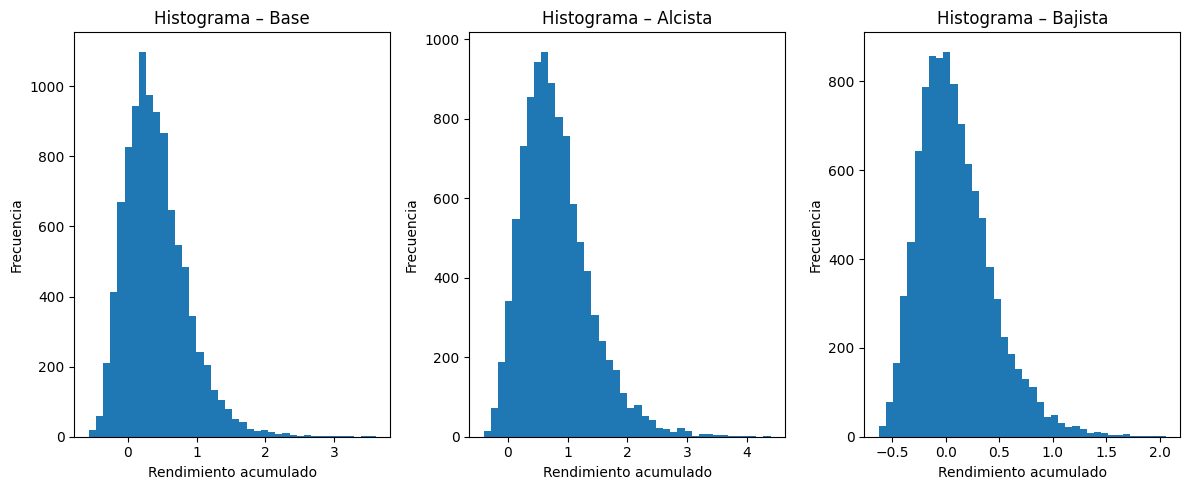

<Figure size 700x400 with 0 Axes>

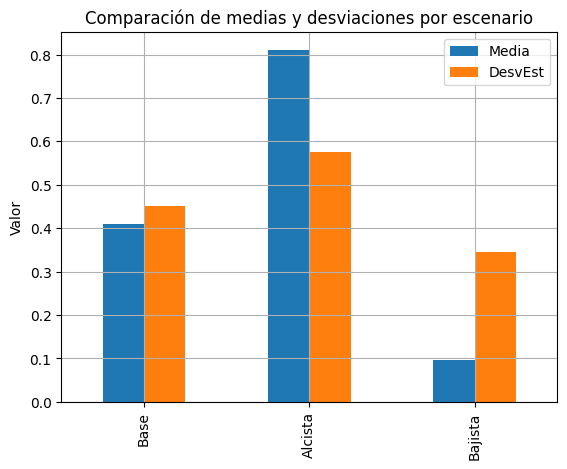


Cuadro comparativo de escenarios:
            Media   DesvEst
Base     0.408983  0.451614
Alcista  0.810905  0.575212
Bajista  0.095889  0.346094


In [ ]:
def simular_portafolio(num_sim, weights, mean_returns, matriz_cov, num_dias):
    """
    Simula trayectorias de un portafolio dado un escenario de medias.
    """
    mu = mean_returns.values.astype(float)
    cov = matriz_cov.values.astype(float)
    w = np.array(weights)

    # Matriz de correlación (Cholesky)
    try:
        L = np.linalg.cholesky(cov)
    except np.linalg.LinAlgError:
        eps = 1e-8
        L = np.linalg.cholesky(cov + eps*np.eye(cov.shape[0]))

    # Simulaciones: rendimientos diarios de los activos
    Z = np.random.normal(0,1,(num_sim,num_dias,len(mu)))
    daily_asset_returns = Z @ L.T + mu    # (num_sim, num_dias, n_activos)

    # Rendimientos del portafolio
    daily_port = daily_asset_returns @ w  # (num_sim, num_dias)
    paths = np.cumprod(1+daily_port, axis=1)

    # Rendimiento acumulado final
    final_returns = paths[:,-1] - 1
    return final_returns


def escenarios_macro(num_sim, weights, mean_returns, matriz_cov, num_dias=252):
    escenarios = {
        "Base": mean_returns,
        "Alcista": mean_returns + 0.001,
        "Bajista": mean_returns - 0.001
    }
    resultados = {}
    for nombre, mu_mod in escenarios.items():
        resultados[nombre] = simular_portafolio(num_sim, weights, mu_mod, matriz_cov, num_dias)
    return resultados


weights = [0.5,0.2,0.3]   # Portafolio ejemplo
np.random.seed(42)

escenarios = escenarios_macro(
    num_sim=10000,
    weights=weights,
    mean_returns=mean_returns,
    matriz_cov=matriz_cov,
    num_dias=252
)


plt.figure(figsize=(12,5))
for i,(nombre,arr) in enumerate(escenarios.items(),1):
    plt.subplot(1,3,i)
    plt.hist(arr,bins=40)
    plt.title(f"Histograma – {nombre}")
    plt.xlabel("Rendimiento acumulado")
    plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

stats = {
    nombre: {"Media": np.mean(arr), "DesvEst": np.std(arr)}
    for nombre, arr in escenarios.items()
}
df_stats = pd.DataFrame(stats).T

plt.figure(figsize=(7,4))
df_stats[["Media","DesvEst"]].plot(kind="bar")
plt.title("Comparación de medias y desviaciones por escenario")
plt.ylabel("Valor")
plt.grid(True)
plt.show()

print("\nCuadro comparativo de escenarios:")
print(df_stats)


**Conclusión:**

- ¿En qué escenario la probabilidad de pérdida es mayor?

Es mayor en el escenario bajista, ya que al reducirse la media de los rendimientos simulados, aumentan las trayectorias con valores negativos.

- ¿Cuál presenta mayor dispersión de resultados?

También se observa en el escenario bajista, porque los rendimientos se distribuyen en un rango más amplio, reflejando más incertidumbre y riesgo.